In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf

from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD

from lib.object_detection_helper import PlotLosses

from lib.plot_utils import graph_model

/Users/adrian.marino/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Dataset

Download from https://www.kaggle.com/ml-lab-itba/yolointroitbadataset. Unzip and config path in reduced_dataset_folder variable.

# Tenemos 5 clases

In [4]:
classes_names = {
    'n04487081': 'Tranvia',
    'n02108089': 'Boxer',
    'n02701002': 'Ambulacia',
    'n02279972': 'Mariposa',
    'n04008634': 'Misil'
}

Setup dataset base and images paths:

In [5]:
reduced_dataset_folder = f'{os.getcwd()}/challenge_dataset'
train_folder = f'{reduced_dataset_folder}/images/train'
val_folder = f'{reduced_dataset_folder}/images/val'

Load Anotations:

In [6]:
def load_annotations_for(group): return np.load(f'{reduced_dataset_folder}/annotations_{group}.npy').flat[0]
    
annotations_dict_train = load_annotations_for('train')
annotations_dict_val = load_annotations_for('val')

In [7]:
classes = list(annotations_dict_train.keys())
[print(f'[code: {code}, name: {classes_names[code]}]') for code in classes]

[code: n04487081, name: Tranvia]
[code: n02108089, name: Boxer]
[code: n02701002, name: Ambulacia]
[code: n02279972, name: Mariposa]
[code: n04008634, name: Misil]


[None, None, None, None, None]

Get annotaions for 'n04487081'(tranvia) class:

In [8]:
annotation = annotations_dict_train['n04487081']

Get data for first tranvia image:

In [9]:
annotation['n04487081_216']

{'width': 500,
 'height': 375,
 'depth': 3,
 'bounding_boxes': [[147, 34, 330, 274]]}

Each annotation has images dimension an channel and one bounding box dimension.

# Build train and validation imagegenerators
https://keras.io/preprocessing/image/

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# For a macbook
target_image_size=(90, 120)
batch_size = 8

# For a laptop with GPU
# target_image_size=(375, 500)
# batch_size = 64

Create image generators that normalize image between 0 and 1:

In [12]:
datagen_train = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=False
)
datagen_val = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=False
)

Ger batch iterators that transform & augement images according as get these from filesystem.

In [13]:
classes

['n04487081', 'n02108089', 'n02701002', 'n02279972', 'n04008634']

In [14]:
train_generator = datagen_train.flow_from_directory(
    classes = classes,
    directory=train_folder,
    target_size=target_image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 1250 images belonging to 5 classes.


In [15]:
val_generator = datagen_val.flow_from_directory(
    classes = classes,
    directory=val_folder,
    target_size=target_image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 250 images belonging to 5 classes.


Index class codes:

In [16]:
idx_2_class = {v:k for k,v in train_generator.class_indices.items()}

In [17]:
idx_2_class

{0: 'n04487081',
 1: 'n02108089',
 2: 'n02701002',
 3: 'n02279972',
 4: 'n04008634'}

# Graph a Batch
Note: Every time we get a bach the image generator brings different images.

Batch:
 - Batch is a tuple of 2 values.
 - First value shape (Batch size, Height, Width, Depth): (8, 90, 120, 3)
 - Second value shape (Batch size, Probability for each class): (8, 5)


Show Batch images:

Ambulacia -> [0. 0. 1. 0. 0.]


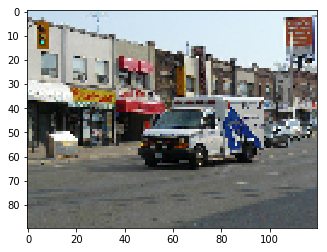

Tranvia -> [1. 0. 0. 0. 0.]


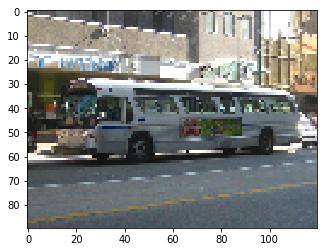

Boxer -> [0. 1. 0. 0. 0.]


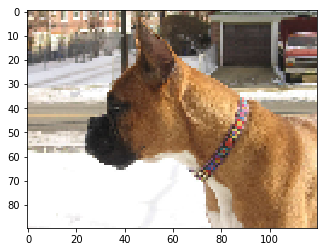

Boxer -> [0. 1. 0. 0. 0.]


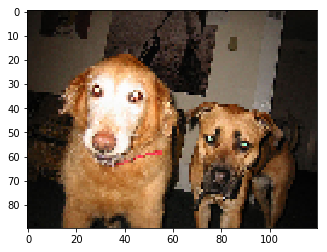

Ambulacia -> [0. 0. 1. 0. 0.]


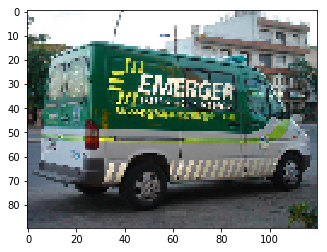

Mariposa -> [0. 0. 0. 1. 0.]


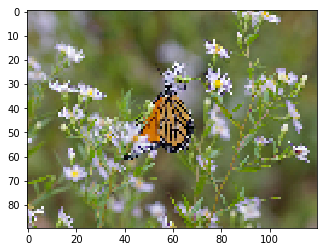

Mariposa -> [0. 0. 0. 1. 0.]


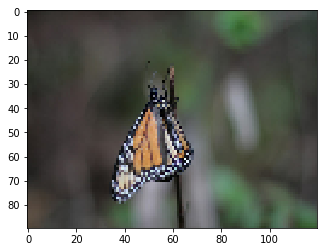

Mariposa -> [0. 0. 0. 1. 0.]


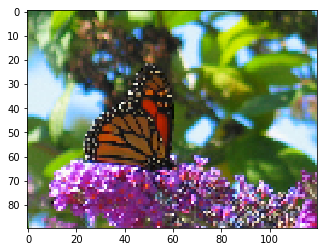

In [18]:
batch = next(val_generator)

print(f'Batch:\n - Batch is a tuple of {len(batch)} values.')
print(f' - First value shape (Batch size, Height, Width, Depth): {batch[0].shape}')
print(f' - Second value shape (Batch size, Probability for each class): {batch[1].shape}')

print(f'\n\nShow Batch images:\n')
for index, image in enumerate(batch[0]):
    plt.imshow(image)
    class_idx = np.argmax(batch[1][index])
    class_id = idx_2_class[class_idx]
    print(f'{classes_names[class_id]} -> {batch[1][index]}')
    plt.show()

# Build model using trasnfer learning with VGG-16

In [19]:
n_classes = len(classes)

In [20]:
target_image_size

(90, 120)

In [21]:
N_trainable = 17

modelVGG16 = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(*target_image_size, 3)
)

gap_layer = GlobalAveragePooling2D()(modelVGG16.output)

classification_layer = Dense(
    n_classes, 
    activation='softmax', 
    name='category_output'
)(gap_layer)


model = Model(
    inputs=modelVGG16.input, 
    outputs=classification_layer
)

print('First trainable layer:', model.layers[N_trainable].name)

for layer in model.layers[N_trainable:]: layer.trainable = True
for layer in model.layers[:N_trainable]: layer.trainable = False

First trainable layer: block5_conv3


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 90, 120, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 120, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 120, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 30, 128)       0         
__________

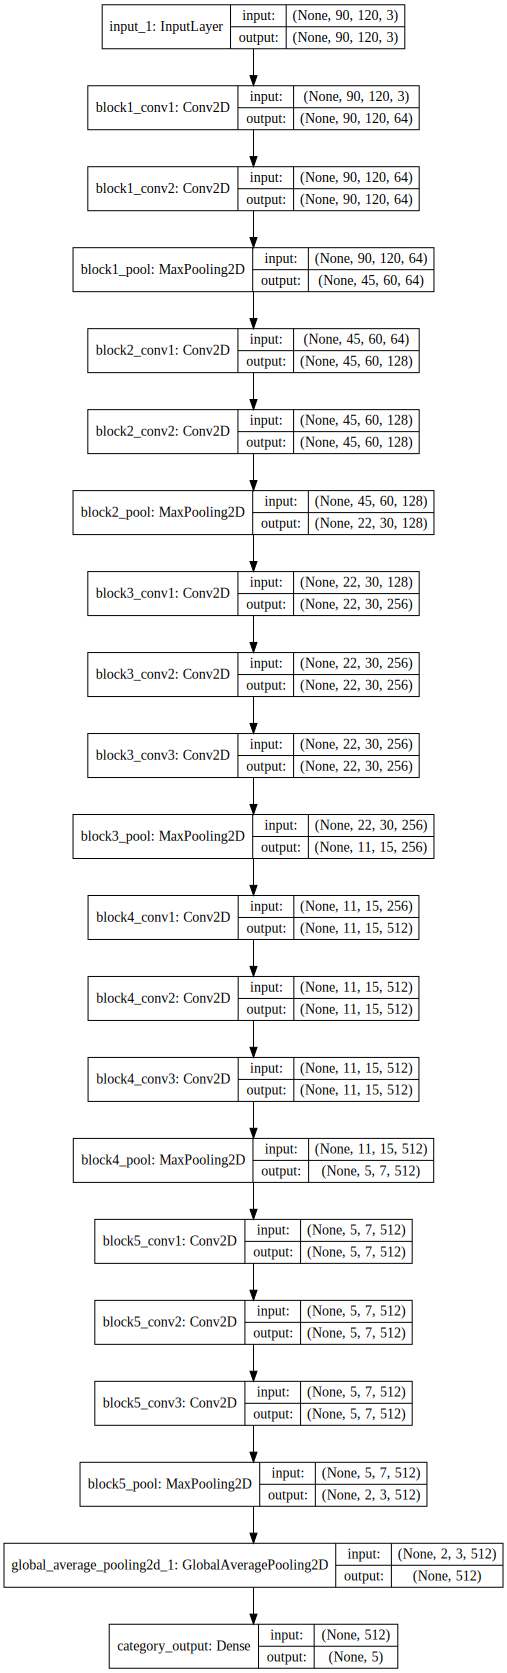

In [22]:
model.summary()
graph_model(model)

In [23]:
filename = 'classif_runtime'

checkpoint = ModelCheckpoint(
    filepath = f'{filename}_best.hdf5', 
    monitor='val_acc', 
    save_best_only=True
)

model.compile(
    loss=["categorical_crossentropy"],
    optimizer=Adam(lr=0.001),
    metrics=["accuracy"]
)

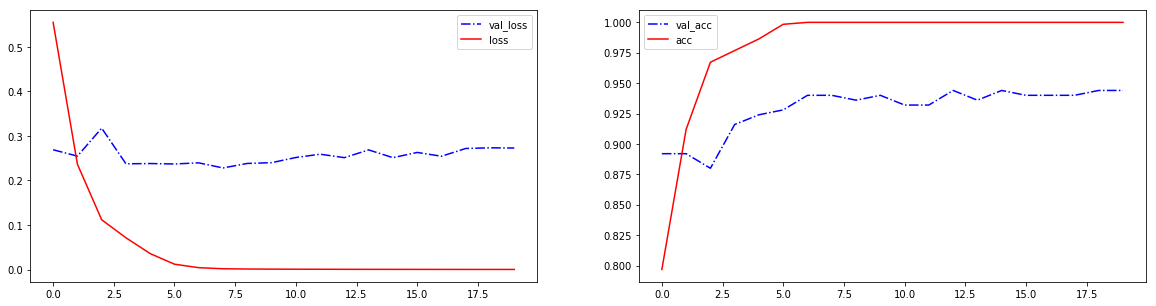

In [24]:
plot_losses = PlotLosses(1)

model.fit_generator(
    train_generator,
    #steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_generator, 
    callbacks = [plot_losses, checkpoint]
)

In [25]:
model.save_weights('model_weights.h5')

# Eval model after training

In [26]:
model.load_weights('model_weights.h5')

In [27]:
loss, acc = model.evaluate_generator(train_generator)

print('Train loss:', loss)
print('Train Acc:', acc)

Train loss: 0.00012581890613673748
Train Acc: 1.0


In [28]:
loss, acc = model.evaluate_generator(val_generator)
print('Val loss:', loss)
print('Val Acc:', acc)

Val loss: 0.2727314388099549
Val Acc: 0.944


In [29]:
model.save()

TypeError: save() missing 1 required positional argument: 'filepath'

# Graph results

### wrong classified images

In [ ]:
generator = val_generator
images_missed = []

for i in range(len(generator)):
    images, class_true = next(generator)

    class_pred = model.predict_on_batch(images)
    indexes = np.logical_not((np.argmax(class_pred, axis = 1) == np.argmax(class_true, axis=1)))
   
    for i, image in enumerate(images[indexes]):
        class_idx = np.argmax(class_pred, axis = 1)[indexes][i]
        class_id = idx_2_class[class_idx]
        print('clase:', classes_names[class_id])
        plt.imshow(image)
        plt.show()
        print(indexes.sum())

# Model without dense layers

## Supongamos una input shape

In [ ]:
input_shape=(375, 500,3)

N_trainable = 17
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
#modelVGG16.summary()

output = modelVGG16.layers[-1].output
print(output)

last_w = output.shape[1].value
last_h = output.shape[2].value
print(last_w, last_h)
# Notar que el shape cambia al cambiar la entrada

In [ ]:
dense_conv = Conv2D(
    filters = n_classes, 
    kernel_size = (last_w, last_h), 
    activation='softmax', 
    name='category_output'
)
classification = dense_conv(
    modelVGG16.output
)
model = Model(
    inputs=modelVGG16.input, 
    outputs=classification
)

In [ ]:
for layer in model.layers[N_trainable:]: layer.trainable = True
for layer in model.layers[:N_trainable]]: layer.trainable = False

In [ ]:
model.summary()
graph_model(model)